In [1]:
#-----------IMPORT UTILITY---------------#
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import tree
import os
import timeit
import time
import glob
import warnings
warnings.filterwarnings("ignore")

IMG_PATH = os.path.join(os.getcwd(), "img")
if not os.path.exists(IMG_PATH):
    os.mkdir(IMG_PATH)

MODEL_PATH = os.path.join(os.getcwd(), "model")
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

DS_PATH = os.path.join(os.getcwd(), "dataset")
if not os.path.exists(DS_PATH):
    os.mkdir(DS_PATH)
    
CKP_PATH = os.path.join(MODEL_PATH, 'ckp.weights.h5')

N_CSV = len(os.listdir(DS_PATH))
#print(N_CSV)

2024-12-10 10:35:03.858944: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#-----------READ CSV---------------#
df = pd.concat(pd.read_csv(file) for file in list(file for file in glob.glob(DS_PATH + "/*.csv")))

In [3]:
df.head().T

,0,1,2,3,4
Dst Port,0,0,67,0,0
Protocol,0,0,17,0,0
Timestamp,22/02/2022 08:17:11,22/02/2022 08:20:07,22/02/2022 08:17:18,22/02/2022 08:22:09,22/02/2022 08:24:11
Flow Duration,115307855,60997457,61149019,60997555,61997503
Tot Fwd Pkts,5,2,5,2,3
...,...,...,...,...,...
Idle Mean,56700000.0,61000000.0,19200000.0,61000000.0,61000000.0
Idle Std,6010057.622,0.0,12500000.0,0.0,0.0
Idle Max,61000000,61000000,32600000,61000000,61000000
Idle Min,52500000,61000000,7999725,61000000,61000000


In [4]:
df.columns

Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

In [5]:
df.shape

(6622534, 80)

In [6]:
#-----------CLEAN DATAFRAME---------------#
df.replace(np.inf, np.nan, inplace=True)
df.replace(-np.inf, np.nan, inplace=True)

In [7]:
df.dropna(inplace=True)

In [8]:
#-----------CHECK DATAFRAME---------------#
df

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,22/02/2022 08:17:11,115307855,5,0,0,0,0,0,...,0,1812348.0,0.0,1812348,1812348,56700000.0,6.010058e+06,61000000,52500000,Benign
1,0,0,22/02/2022 08:20:07,60997457,2,0,0,0,0,0,...,0,0.0,0.0,0,0,61000000.0,0.000000e+00,61000000,61000000,Benign
2,67,17,22/02/2022 08:17:18,61149019,5,0,1500,0,300,300,...,8,3530939.0,0.0,3530939,3530939,19200000.0,1.250000e+07,32600000,7999725,Benign
3,0,0,22/02/2022 08:22:09,60997555,2,0,0,0,0,0,...,0,0.0,0.0,0,0,61000000.0,0.000000e+00,61000000,61000000,Benign
4,0,0,22/02/2022 08:24:11,61997503,3,0,0,0,0,0,...,0,999909.0,0.0,999909,999909,61000000.0,0.000000e+00,61000000,61000000,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048565,80,6,23/02/2022 10:53:23,10156986,5,5,1089,1923,587,0,...,20,0.0,0.0,0,0,0.0,0.000000e+00,0,0,Benign
1048566,80,6,23/02/2022 10:53:33,117,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000e+00,0,0,Benign
1048567,80,6,23/02/2022 10:53:28,5095331,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000e+00,0,0,Benign
1048568,80,6,23/02/2022 10:53:28,5235511,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000e+00,0,0,Benign


In [9]:
#-----------CONVERT TIMESTAMP---------------#
def extract_time_features(df, Timestamp):
    df[Timestamp] = pd.to_datetime(df[Timestamp], errors='coerce')
    
    # Extract time features
    df['Year'] = df[Timestamp].dt.year
    df['Month'] = df[Timestamp].dt.month
    df['Day'] = df[Timestamp].dt.day
    df['Hour'] = df[Timestamp].dt.hour
    df['Minute'] = df[Timestamp].dt.minute
    df['Second'] = df[Timestamp].dt.second
    df['DayOfWeek'] = df[Timestamp].dt.dayofweek
    
    return df

In [10]:
#-----------CHECK NEW DATAFRAME---------------#
new_df = extract_time_features(df, 'Timestamp')
new_df

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Idle Max,Idle Min,Label,Year,Month,Day,Hour,Minute,Second,DayOfWeek
0,0,0,2022-02-22 08:17:11,115307855,5,0,0,0,0,0,...,61000000,52500000,Benign,2022,2,22,8,17,11,1
1,0,0,2022-02-22 08:20:07,60997457,2,0,0,0,0,0,...,61000000,61000000,Benign,2022,2,22,8,20,7,1
2,67,17,2022-02-22 08:17:18,61149019,5,0,1500,0,300,300,...,32600000,7999725,Benign,2022,2,22,8,17,18,1
3,0,0,2022-02-22 08:22:09,60997555,2,0,0,0,0,0,...,61000000,61000000,Benign,2022,2,22,8,22,9,1
4,0,0,2022-02-22 08:24:11,61997503,3,0,0,0,0,0,...,61000000,61000000,Benign,2022,2,22,8,24,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048565,80,6,2022-02-23 10:53:23,10156986,5,5,1089,1923,587,0,...,0,0,Benign,2022,2,23,10,53,23,2
1048566,80,6,2022-02-23 10:53:33,117,2,0,0,0,0,0,...,0,0,Benign,2022,2,23,10,53,33,2
1048567,80,6,2022-02-23 10:53:28,5095331,3,1,0,0,0,0,...,0,0,Benign,2022,2,23,10,53,28,2
1048568,80,6,2022-02-23 10:53:28,5235511,3,1,0,0,0,0,...,0,0,Benign,2022,2,23,10,53,28,2


In [11]:
matches = list((x for x in df['Label'].unique() if x != 'Benign'))
df.replace(to_replace=matches, value="Malicious", inplace=True)

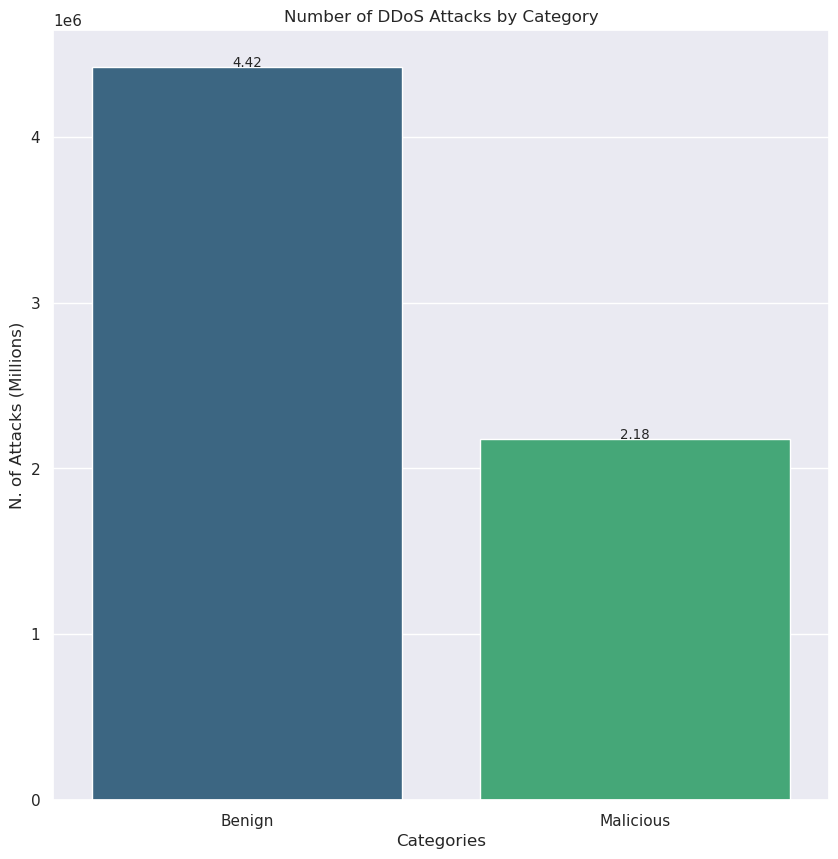

In [12]:
#-----------CATEGORY DISTRIBUTION---------------#
labels = df['Label'].unique()
labels.sort()
sns.set_theme(style="darkgrid")
plt.figure(figsize=[10,10])
ax = sns.countplot(data=df, x='Label', hue='Label', legend=False, palette=sns.color_palette("viridis", len(labels)))
ax.set(title = 'Number of DDoS Attacks by Category')
ax.set_ylabel('N. of Attacks (Millions)')
ax.set_xlabel('Categories')
sns.set(font_scale=0.8)
#for c in ax.containers:
#    ax.bar_label(c)
for p in ax.patches:
    value = '{:.2f}'.format(p.get_height()/1000000)
    ax.text(p.get_x()+p.get_width()/2, p.get_height(), format(p.get_height()/1000000, '.2f'), ha="center")
plt.savefig(os.path.join(IMG_PATH,'ddos-category.png'))
plt.show()

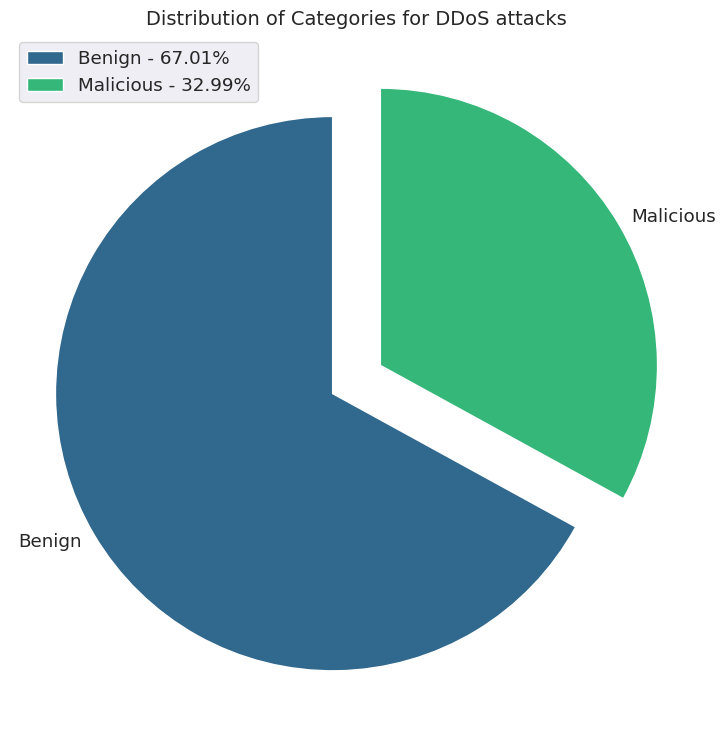

In [13]:
sns.set(font_scale=1.2)
plt.figure(figsize=[9,9])
expl_arr = []
for z in df['Label'].value_counts().sort_index().index:
    expl_arr.append(0.1)
plt.pie(df['Label'].value_counts().values, labels=df['Label'].value_counts().index, autopct=(lambda p: format(p, '.2f') if p > 100 else None), colors=sns.color_palette("viridis", len(expl_arr)), shadow=False, startangle=90, labeldistance=1.05, explode=expl_arr)
plt.title('Distribution of Categories for DDoS attacks', fontsize=14)
vals = ['{0} - {1:1.2f}%'.format(i,j) for i,j in zip(df['Label'].value_counts().index, 100.*df['Label'].value_counts().values/df['Label'].value_counts().values.sum())]
plt.legend(df['Label'].value_counts().values, labels=vals, loc="best")
plt.savefig(os.path.join(IMG_PATH,'ddos-category-dist.png'))
plt.show()

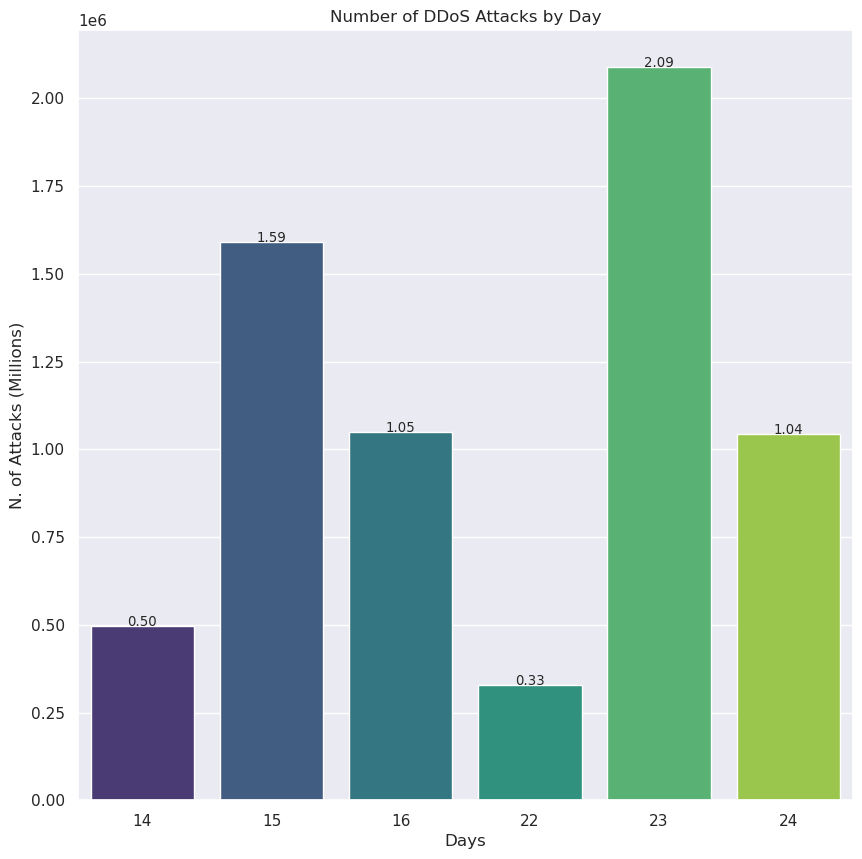

In [14]:
#-----------DAY DISTRIBUTION---------------#
days = df['Day'].unique()
#print(hours)
sns.set_theme(style="darkgrid")
plt.figure(figsize=[10,10])
ax=sns.countplot(data=df, x = 'Day', hue='Day', palette=sns.color_palette("viridis", len(days)), legend=False)
ax.set(title = 'Number of DDoS Attacks by Day')
ax.set_ylabel('N. of Attacks (Millions)')
ax.set_xlabel('Days')
sns.set(font_scale=0.8)
total = df['Day'].count()
#for c in ax.containers:
    #ax.bar_label(c)
for p in ax.patches:
    value = '{:.2f}'.format(p.get_height()/1000000)
    ax.text(p.get_x()+p.get_width()/2, p.get_height(), format(p.get_height()/1000000, '.2f'), ha="center")
plt.savefig(os.path.join(IMG_PATH,'ddos-day.png'))
plt.show()

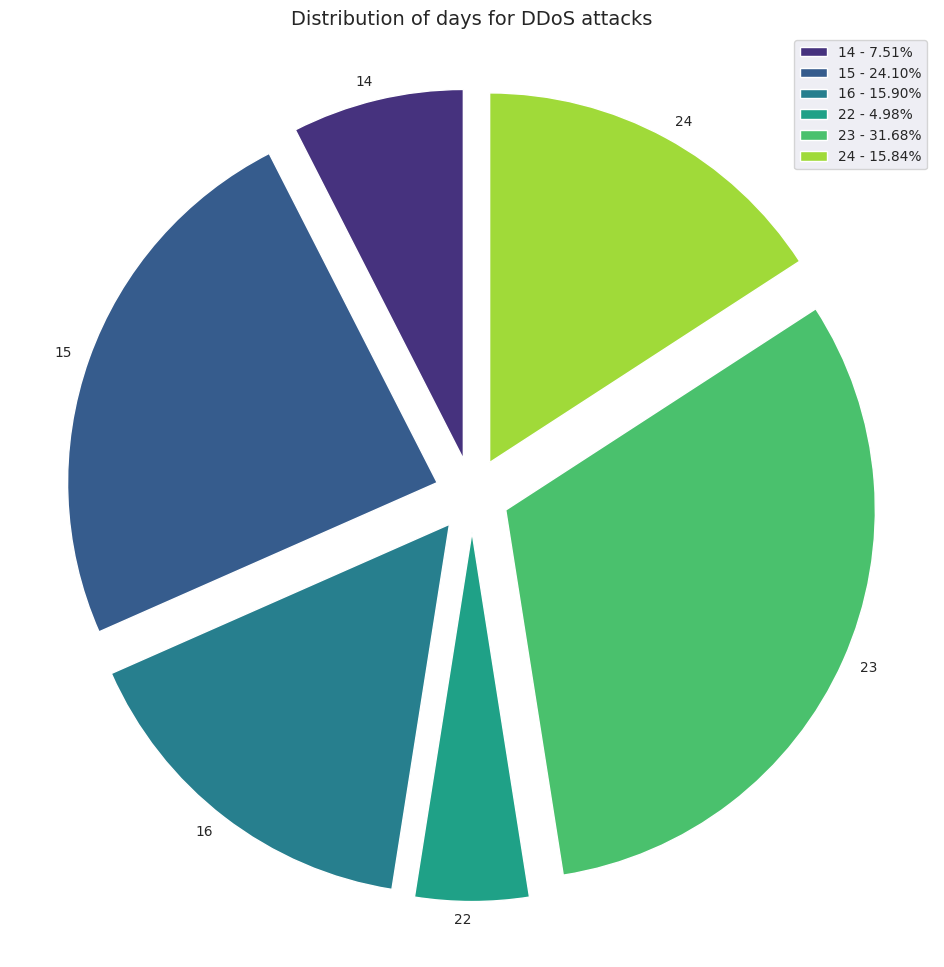

In [15]:
sns.set(font_scale=0.9)
plt.figure(figsize=[12,12])
expl_arr = []
for z in df['Day'].value_counts().sort_index().index:
    expl_arr.append(0.1)
plt.pie(df['Day'].value_counts().sort_index().values, labels=df['Day'].value_counts().sort_index().index, autopct=(lambda p: format(p, '.2f') if p > 100 else None), colors=sns.color_palette("viridis", len(expl_arr)), shadow=False, startangle=90, labeldistance=1.05, explode=expl_arr)
plt.title('Distribution of days for DDoS attacks', fontsize=14)
vals = ['{0} - {1:1.2f}%'.format(i,j) for i,j in zip(df['Day'].value_counts().sort_index().index, 100.*df['Day'].value_counts().sort_index().values/df['Day'].value_counts().sort_index().values.sum())]
plt.legend(df['Day'].value_counts().sort_index().values, labels=vals, loc="best")
plt.savefig(os.path.join(IMG_PATH,'ddos-day-dist.png'))
plt.show()

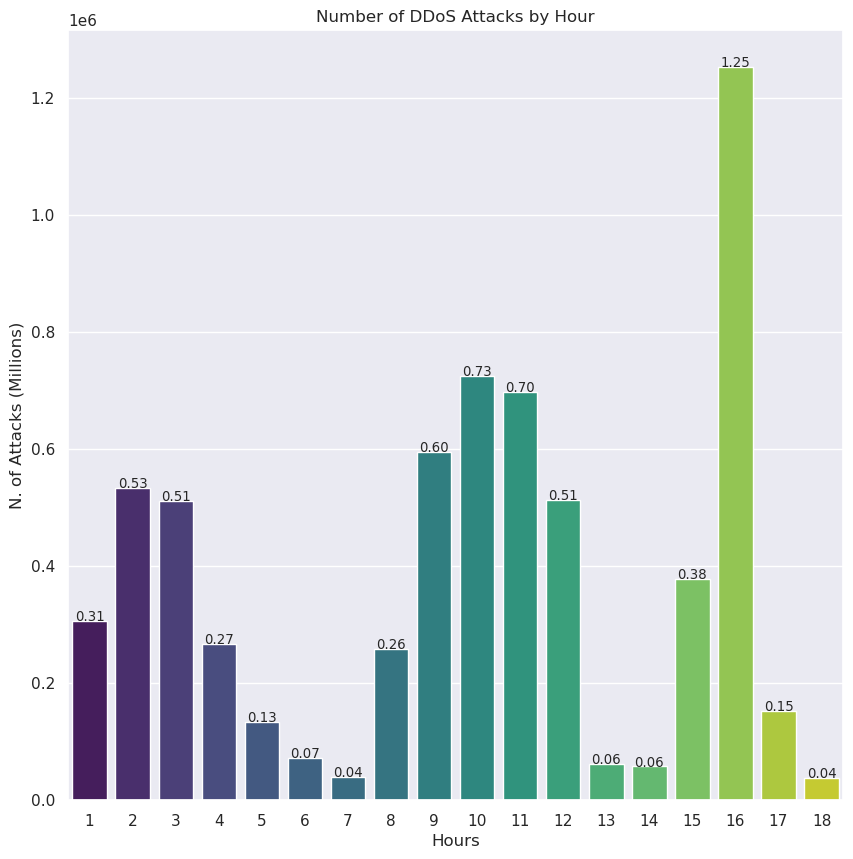

In [16]:
#-----------HOUR DISTRIBUTION---------------#
hours = df['Hour'].unique()
#print(hours)
sns.set_theme(style="darkgrid")
plt.figure(figsize=[10,10])
ax=sns.countplot(data=df, x = 'Hour', hue='Hour', legend=False, palette=sns.color_palette("viridis", len(hours)))
ax.set(title = 'Number of DDoS Attacks by Hour')
ax.set_ylabel('N. of Attacks (Millions)')
ax.set_xlabel('Hours')
sns.set(font_scale=0.8)
total = df['Hour'].count()
#for c in ax.containers:
#    ax.bar_label(c)
for p in ax.patches:
    value = '{:.2f}'.format(p.get_height()/1000000)
    ax.text(p.get_x()+p.get_width()/2, p.get_height(), format(p.get_height()/1000000, '.2f'), ha="center")
plt.savefig(os.path.join(IMG_PATH,'ddos-hour.png'))
plt.show()

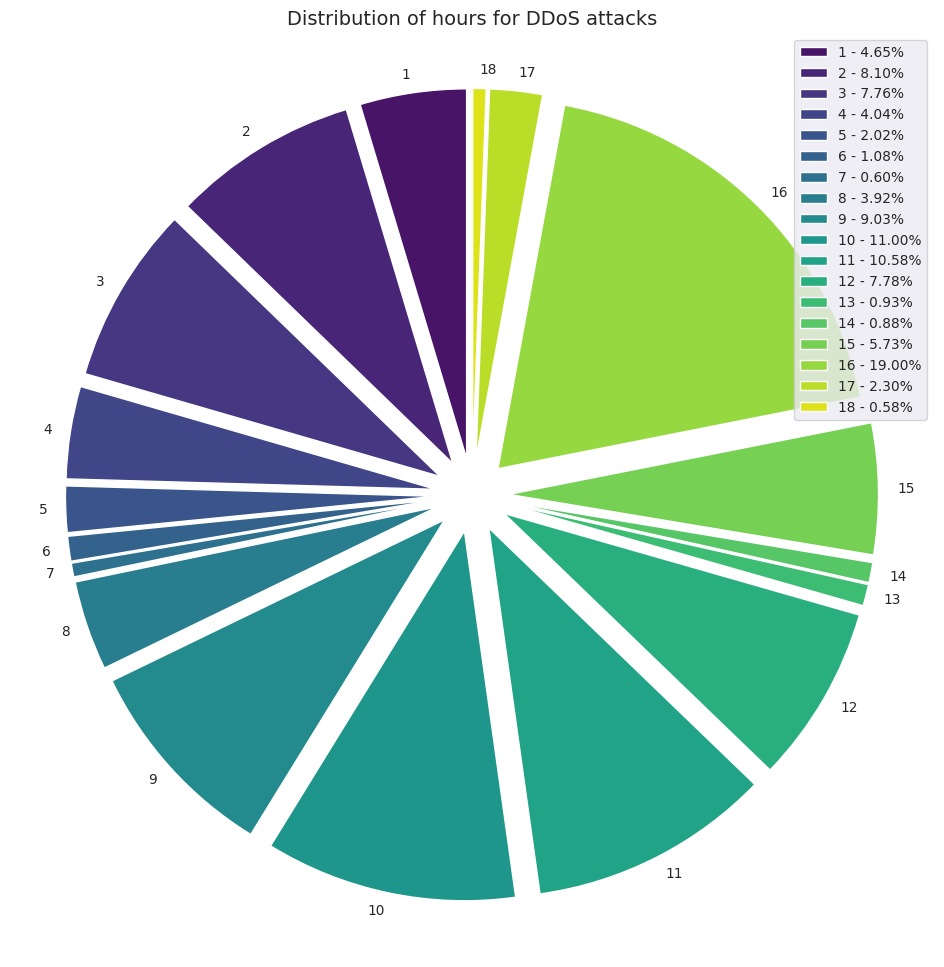

In [17]:
sns.set(font_scale=0.9)
plt.figure(figsize=[12,12])
expl_arr = []
for z in df['Hour'].value_counts().sort_index().index:
    expl_arr.append(0.1)
plt.pie(df['Hour'].value_counts().sort_index().values, labels=df['Hour'].value_counts().sort_index().index, autopct=(lambda p: format(p, '.2f') if p > 100 else None), colors=sns.color_palette("viridis", len(expl_arr)), shadow=False, startangle=90, labeldistance=1.05, explode=expl_arr)
plt.title('Distribution of hours for DDoS attacks', fontsize=14)
vals = ['{0} - {1:1.2f}%'.format(i,j) for i,j in zip(df['Hour'].value_counts().sort_index().index, 100.*df['Hour'].value_counts().sort_index().values/df['Hour'].value_counts().sort_index().values.sum())]
plt.legend(df['Hour'].value_counts().sort_index().values, labels=vals, loc="best")
plt.savefig(os.path.join(IMG_PATH,'ddos-hour-dist.png'))
plt.show()

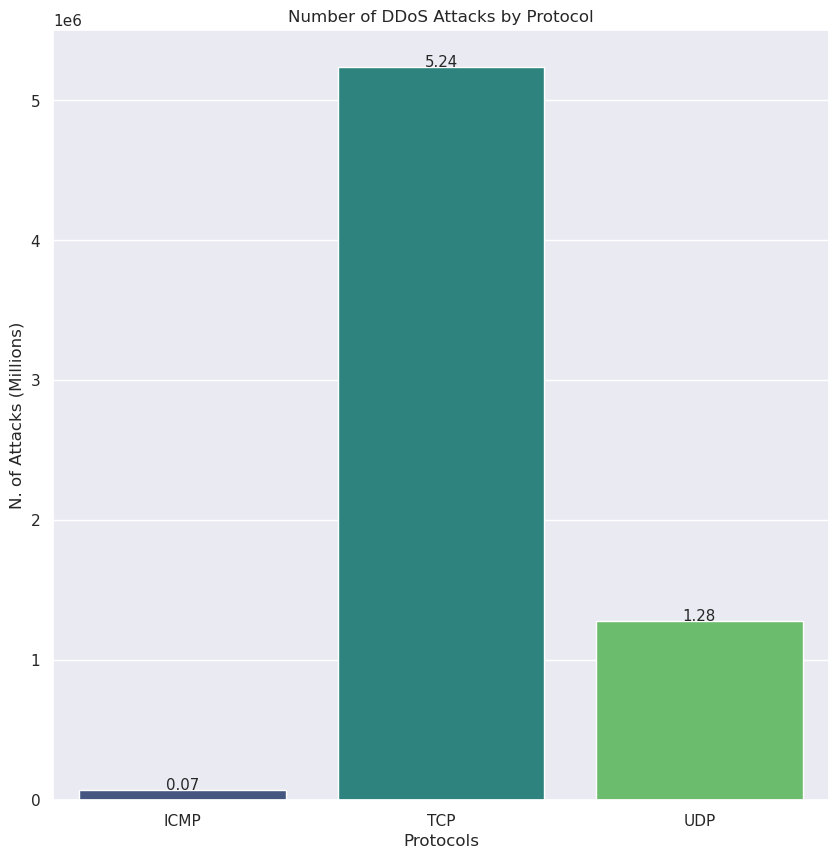

In [18]:
#-----------PROTOCOL DISTRIBUTION---------------#
protocols = ['TCP', 'UDP', 'ICMP']
protocols.sort()
sns.set_theme(style="darkgrid")
plt.figure(figsize=[10,10])
ax = sns.countplot(data=df, x='Protocol', hue='Protocol', order=df['Protocol'].value_counts().sort_index().index, legend=False, palette=sns.color_palette("viridis", len(protocols)))
ax.set(title = 'Number of DDoS Attacks by Protocol')
ax.set_ylabel('N. of Attacks (Millions)')
ax.set_xlabel('Protocols')
sns.set(font_scale=0.9)
ax.set_xticklabels(protocols)
#for c in ax.containers:
#    ax.bar_label(c)
for p in ax.patches:
    value = '{:.2f}'.format(p.get_height()/1000000)
    ax.text(p.get_x()+p.get_width()/2, p.get_height(), format(p.get_height()/1000000, '.2f'), ha="center")
plt.savefig(os.path.join(IMG_PATH,'ddos-protocol.png'))
plt.show()

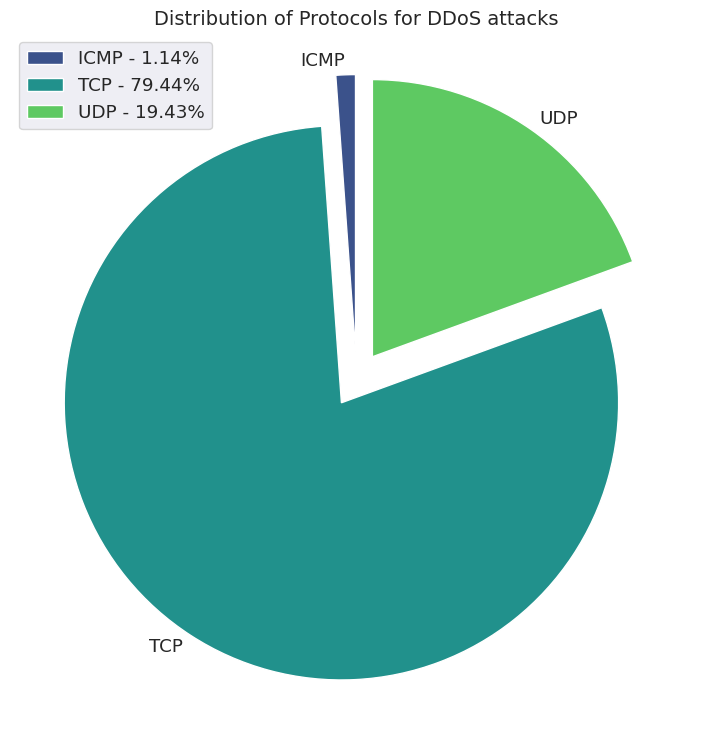

In [19]:
sns.set(font_scale=1.2)
plt.figure(figsize=[9,9])
expl_arr = []
protocols = ['TCP', 'UDP', 'ICMP']
protocols.sort()
for z in df['Protocol'].value_counts().sort_index().index:
    expl_arr.append(0.1)
plt.pie(df['Protocol'].value_counts().sort_index().values, labels=protocols, autopct=(lambda p: format(p, '.2f') if p > 100 else None), colors=sns.color_palette("viridis", len(expl_arr)), shadow=False, startangle=90, labeldistance=1.05, explode=expl_arr)
plt.title('Distribution of Protocols for DDoS attacks', fontsize=14)
vals = ['{0} - {1:1.2f}%'.format(i,j) for i,j in zip(protocols, 100.*df['Protocol'].value_counts().sort_index().values/df['Protocol'].value_counts().values.sum())]
plt.legend(df['Protocol'].value_counts().sort_index().values, labels=vals, loc="best")
plt.savefig(os.path.join(IMG_PATH,'ddos-protocol-dist.png'))
plt.show()

In [20]:
df.replace(to_replace="Benign", value=0, inplace=True)
df.replace(to_replace="Malicious", value=1, inplace=True)

In [21]:
#-----------SEPARATE INPUT/OUTPUT---------------#
df.drop(['Timestamp'], axis=1,inplace=True)
df.drop(['Year'], axis=1,inplace=True)
df.drop(['Month'], axis=1,inplace=True)
df.drop(['Day'], axis=1,inplace=True)
df.drop(['DayOfWeek'], axis=1,inplace=True)
df.drop(['Hour'], axis=1,inplace=True)
df.drop(['Minute'], axis=1,inplace=True)
df.drop(['Second'], axis=1,inplace=True)
x = df.drop(['Label'], axis=1)
y = df['Label'].apply(pd.to_numeric)

In [22]:
ms = MinMaxScaler()
x = ms.fit_transform(x)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
print(X_train.shape, X_test.shape)

(5936459, 78) (659607, 78)


In [24]:
labels = ['benign','malicious']

In [25]:
class_name = ["Decision Tree", "Quadratic Discriminant Analysis", "Logistic Regression", "Stochastiic Gradient", "Deep Neural Network"]
class_acc = []
class_time = []

In [26]:
st = time.time()
#%%time
#-----------FIT MODEL DT---------------#
dt_model = DecisionTreeClassifier(max_depth=3, splitter="random")
#dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred=dt_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy of Decision Tree Classifier : %.2f' % (accuracy*100))
print(classification_report(y_test, y_pred, target_names = labels))
et = time.time() - st
class_acc.append(accuracy*100)
class_time.append(et)

Accuracy of Decision Tree Classifier : 87.43
              precision    recall  f1-score   support

      benign       0.92      0.89      0.90    442269
   malicious       0.79      0.84      0.81    217338

    accuracy                           0.87    659607
   macro avg       0.86      0.87      0.86    659607
weighted avg       0.88      0.87      0.88    659607



In [27]:
st = time.time()
#%%time
#-----------FIT MODEL QDA---------------#
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, y_train)
y_pred=qda_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy of Quadratic Discriminant Analysis Classifier : %.2f' % (accuracy*100))
print(classification_report(y_test, y_pred, target_names = labels))
et = time.time() - st
class_acc.append(accuracy*100)
class_time.append(et)

Accuracy of Quadratic Discriminant Analysis Classifier : 55.53
              precision    recall  f1-score   support

      benign       0.98      0.34      0.51    442269
   malicious       0.42      0.99      0.59    217338

    accuracy                           0.56    659607
   macro avg       0.70      0.67      0.55    659607
weighted avg       0.80      0.56      0.54    659607



In [28]:
st = time.time()
#%%time
#-----------FIT MODEL LR---------------#
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred=lr_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy of Logistic Regression Classifier : %.2f' % (accuracy*100))
print(classification_report(y_test, y_pred, target_names = labels))
et = time.time() - st
class_acc.append(accuracy*100)
class_time.append(et)

Accuracy of Logistic Regression Classifier : 95.15
              precision    recall  f1-score   support

      benign       0.95      0.98      0.96    442269
   malicious       0.96      0.89      0.92    217338

    accuracy                           0.95    659607
   macro avg       0.95      0.94      0.94    659607
weighted avg       0.95      0.95      0.95    659607



In [29]:
st = time.time()
#%%time
#-----------FIT MODEL SGD---------------#
sgd_model = SGDClassifier(loss="hinge", penalty="l2")
sgd_model.fit(X_train, y_train)
y_pred=sgd_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy of Stochastic Gradient Classifier : %.2f' % (accuracy*100))
print(classification_report(y_test, y_pred, target_names = labels))
et = time.time() - st
class_acc.append(accuracy*100)
class_time.append(et)

Accuracy of Stochastic Gradient Classifier : 95.48
              precision    recall  f1-score   support

      benign       0.95      0.98      0.97    442269
   malicious       0.97      0.89      0.93    217338

    accuracy                           0.95    659607
   macro avg       0.96      0.94      0.95    659607
weighted avg       0.96      0.95      0.95    659607



In [30]:
#-----------DEFINE MODEL WITH ADAM ALGORITHM---------------#
model = keras.Sequential()
model.add(Dense(24 , input_shape=(X_train.shape[1],) , activation="relu" , name="Layer1"))
model.add(Dense(10 , activation="relu" , name="Layer2"))
model.add(Dense(1 , activation="sigmoid" , name="OutLayer"))
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile( optimizer=opt, loss="binary_crossentropy", metrics=['accuracy', tf.keras.metrics.AUC()])
#model.compile( optimizer=opt, loss="binary_crossentropy", metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Layer1 (Dense)                  │ (None, 24)             │         1,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer2 (Dense)                  │ (None, 10)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutLayer (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,157 (8.43 KB)

 Trainable params: 2,157 (8.43 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model_ckp=tf.keras.callbacks.ModelCheckpoint(
    filepath=CKP_PATH,
    monitor="val_loss",
    mode="auto",
    save_best_only=True,
    save_weights_only=True
)

In [32]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.9,
    monitor="val_loss",
    mode="auto",
    cooldown=0,
    patience=5,
    verbose=1,
    min_le=1e-6
)

In [33]:
#%%time
#-----------FIT MODEL DNN---------------#
st = time.time()
history_org = model.fit(
    X_train, 
    y_train, 
    batch_size=1024*N_CSV, 
    epochs=10, verbose=2, 
    callbacks=[model_ckp, reduce_lr], 
    #callbacks=None, 
    validation_data=(X_test,y_test), 
    shuffle=True, 
    class_weight=None, 
    sample_weight=None, 
    initial_epoch=0)
et = time.time() - st
loss, accuracy, *check = model.evaluate(X_test, y_test)
print('Accuracy of Deep neural Network : %.2f' % (accuracy*100))
class_acc.append(accuracy*100)
class_time.append(et)

2024-12-10 10:55:44.437366: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1852175208 exceeds 10% of free system memory.


Epoch 1/10
829/829 - 14s - 16ms/step - accuracy: 0.9754 - auc: 0.9893 - loss: 0.0816 - val_accuracy: 0.9877 - val_auc: 0.9917 - val_loss: 0.0549 - learning_rate: 0.0100
Epoch 2/10
829/829 - 9s - 11ms/step - accuracy: 0.9875 - auc: 0.9922 - loss: 0.0532 - val_accuracy: 0.9880 - val_auc: 0.9928 - val_loss: 0.0507 - learning_rate: 0.0100
Epoch 3/10
829/829 - 10s - 11ms/step - accuracy: 0.9880 - auc: 0.9926 - loss: 0.0511 - val_accuracy: 0.9886 - val_auc: 0.9927 - val_loss: 0.0498 - learning_rate: 0.0100
Epoch 4/10
829/829 - 8s - 10ms/step - accuracy: 0.9882 - auc: 0.9928 - loss: 0.0502 - val_accuracy: 0.9886 - val_auc: 0.9926 - val_loss: 0.0493 - learning_rate: 0.0100
Epoch 5/10
829/829 - 9s - 11ms/step - accuracy: 0.9883 - auc: 0.9929 - loss: 0.0496 - val_accuracy: 0.9880 - val_auc: 0.9927 - val_loss: 0.0498 - learning_rate: 0.0100
Epoch 6/10
829/829 - 9s - 11ms/step - accuracy: 0.9883 - auc: 0.9930 - loss: 0.0493 - val_accuracy: 0.9886 - val_auc: 0.9933 - val_loss: 0.0480 - learning_rat

In [34]:
df_res = pd.DataFrame()
df_res['Name'] = class_name
df_res['Accuracy'] = class_acc
df_res['Execution Time'] = class_time
df_res = df_res.sort_values(by=['Accuracy'], ascending = False)
df_res

,Name,Accuracy,Execution Time
4,Deep Neural Network,98.876905,101.496034
3,Stochastiic Gradient,95.480491,31.556996
2,Logistic Regression,95.148172,168.175483
0,Decision Tree,87.434791,35.084984
1,Quadratic Discriminant Analysis,55.534432,339.321120


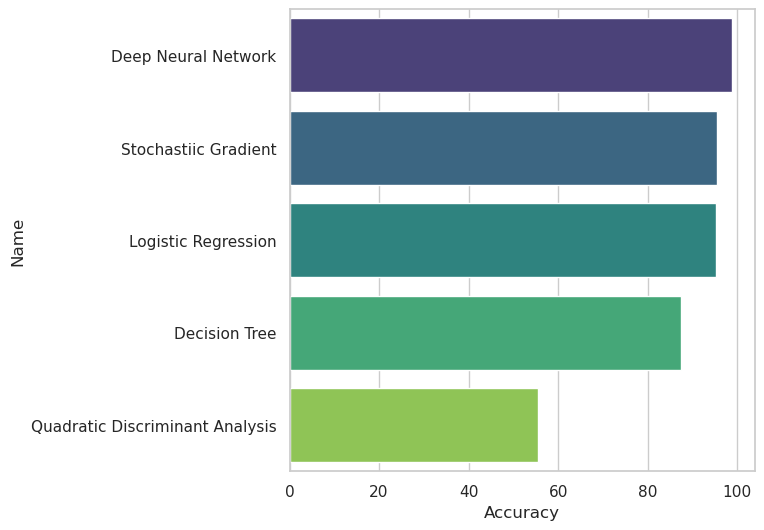

In [35]:
sns.set(style="whitegrid", rc={'figure.figsize':(6,6)}, palette=sns.color_palette("viridis", len(class_name)))
ax = sns.barplot(y="Name", x="Accuracy", hue="Name", data=df_res, legend=False)
plt.savefig(os.path.join(IMG_PATH,'ddos-best-class.png'))
plt.show()

In [36]:
#-----------SAVE BEST CHECKPOINT FOR DNN---------------#
model.load_weights(CKP_PATH)

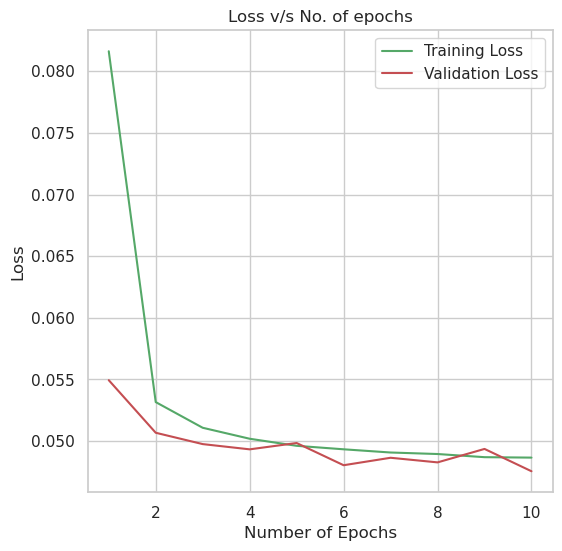

In [37]:
loss = history_org.history['loss']
val_loss = history_org.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Loss v/s No. of epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(IMG_PATH,'loss.png'))
plt.show()

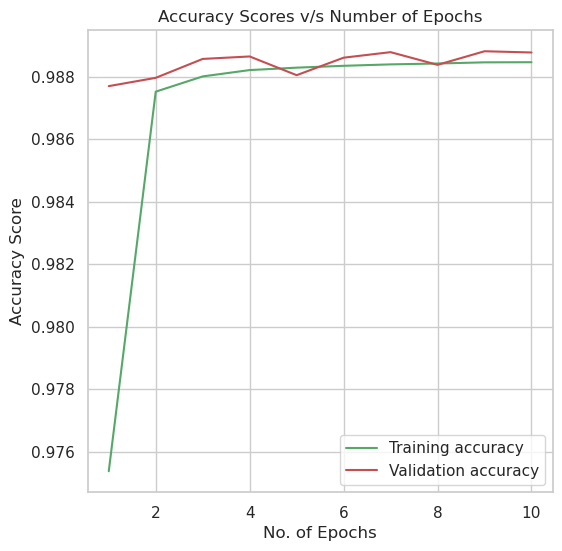

In [38]:
loss = history_org.history['accuracy']
val_loss = history_org.history['val_accuracy']
plt.plot(epochs, loss, 'g', label = 'Training accuracy')
plt.plot(epochs, val_loss, 'r', label = 'Validation accuracy')
plt.title('Accuracy Scores v/s Number of Epochs')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy Score')
plt.legend()
plt.savefig(os.path.join(IMG_PATH,'acc.png'))
plt.show()

In [39]:
classes = model.predict(X_test)

20613/20613 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step


In [40]:
y_pred = []
for i in classes:
    if i > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
y_pred[:20]

[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]

In [41]:
labels = ['benign','malicious']
print(classification_report(y_test, y_pred, target_names = labels))

              precision    recall  f1-score   support

      benign       0.98      1.00      0.99    442269
   malicious       1.00      0.97      0.98    217338

    accuracy                           0.99    659607
   macro avg       0.99      0.98      0.99    659607
weighted avg       0.99      0.99      0.99    659607



In [42]:
from itertools import product
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    cm1 = cm
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] 
        thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(cm1[i, j])+ " ("+ str(cm[i, j]*100)+"%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join(IMG_PATH,'conf-matrix.png'))
    plt.show()

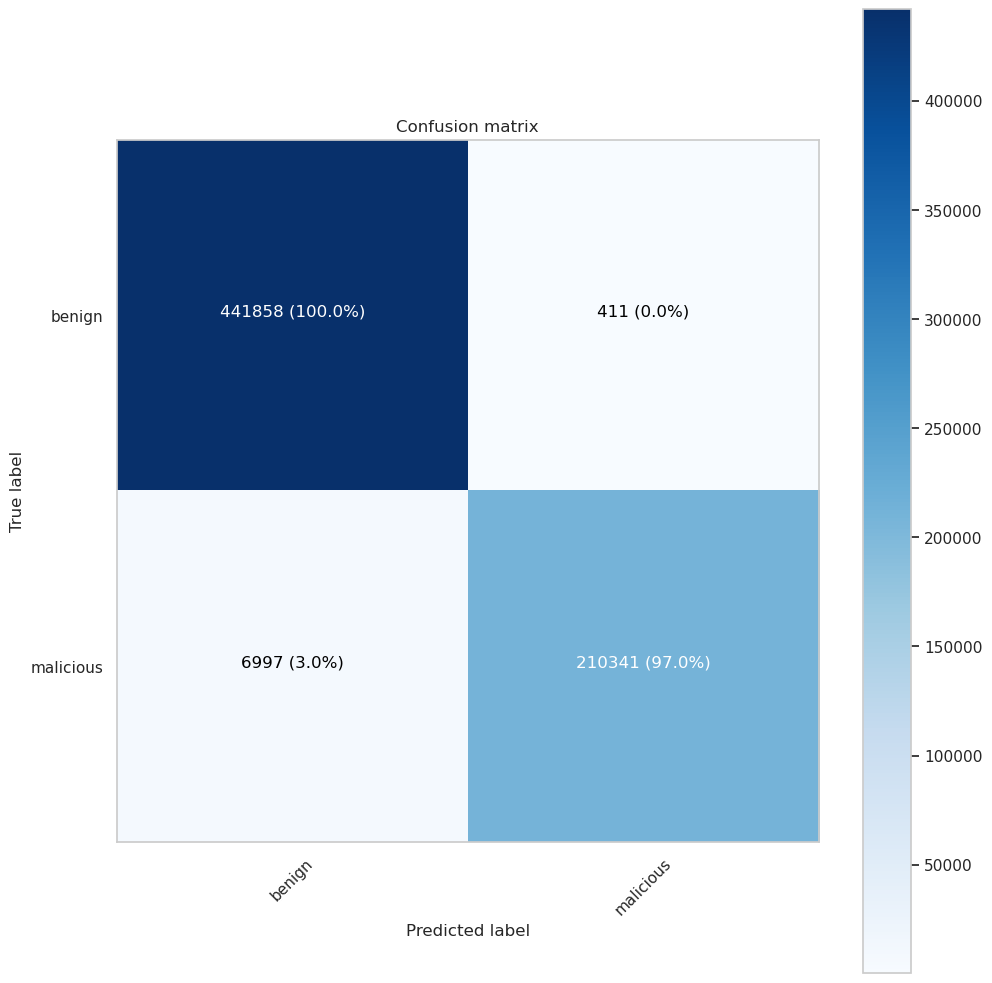

In [43]:
confusion_mtx = confusion_matrix(y_test, y_pred) 
plot_confusion_matrix(confusion_mtx, classes = labels)

Area under the curve(AUC) is: 0.993708404633548


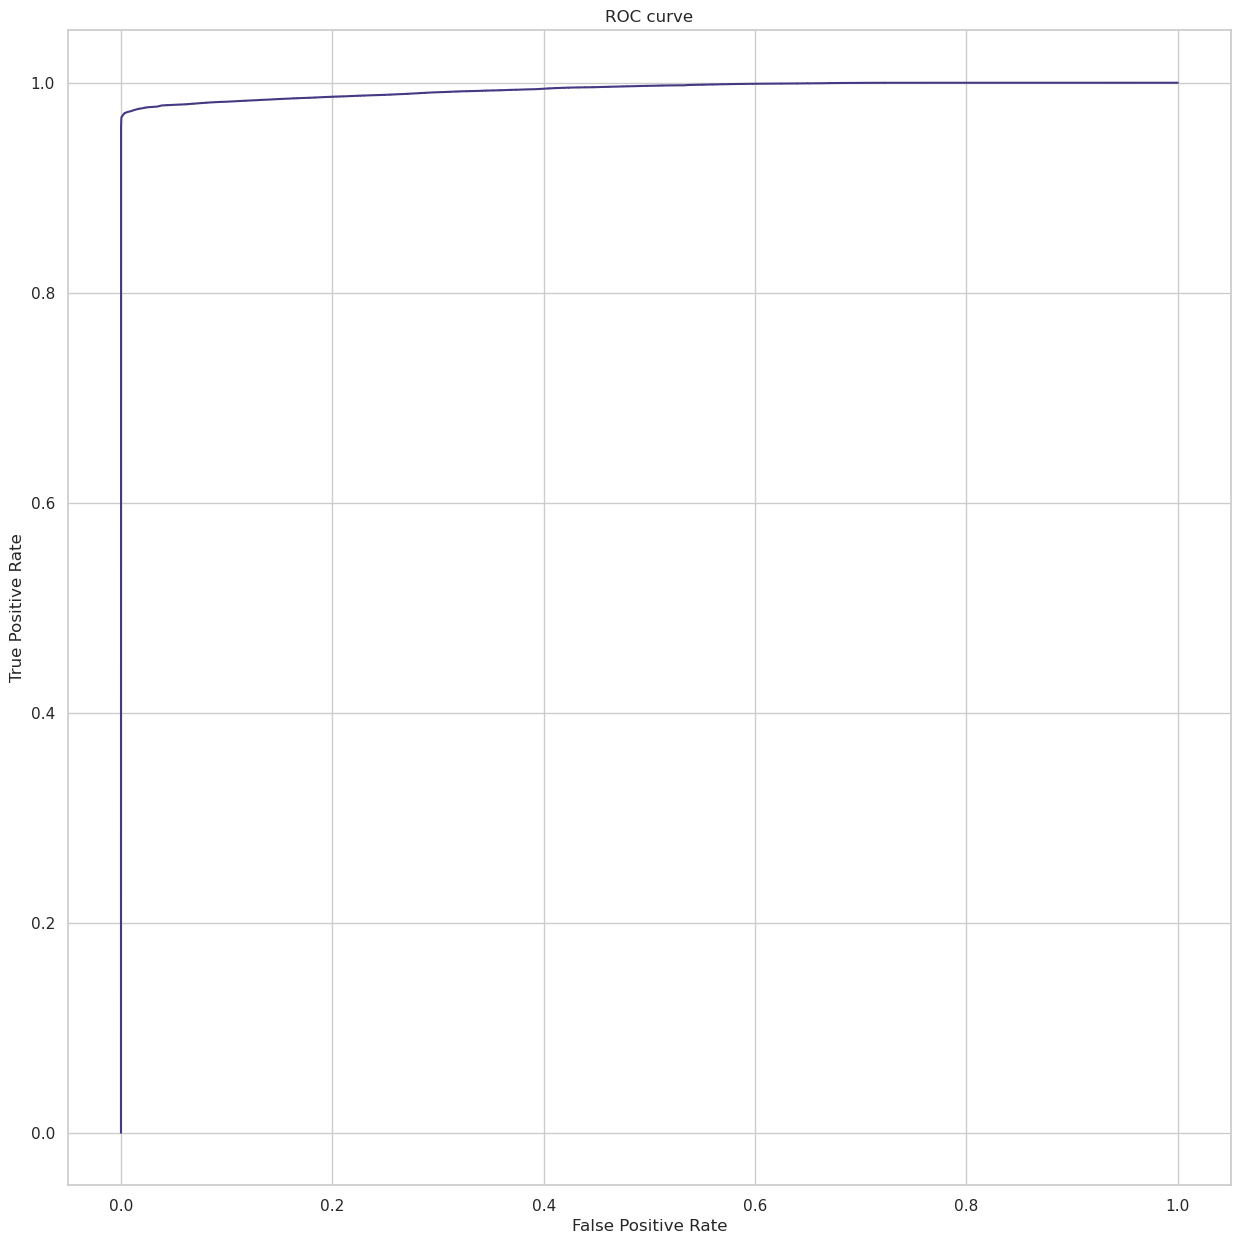

In [44]:
plt.figure(figsize=(15,15))
#history,model_layers,model = model_builder_crv(X_train, X_test, y_train, y_test)    
y_predicted = model(X_test)
fpr, tpr, keras_thr = roc_curve(y_test, y_predicted)
auc_crv = auc(fpr, tpr)
print(f"Area under the curve(AUC) is: {auc_crv}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.savefig(os.path.join(IMG_PATH,'roc-curve.png'))
plt.show()